In [1]:
#Calculating the escape fraction Epsilon as a function of Black Hole Mass
import matplotlib
#matplotlib.use('Agg')
import yt
import numpy as np
import sys
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import glob
from yt.utilities.physical_constants import mh, mp, me, G, kboltz, pi
from math import pi
from yt.units.yt_array import YTQuantity, YTArray




In [2]:
def BondiRadius(M_BH, cs, v):
    R = G * M_BH / (cs*cs + v*v)
    return R


In [3]:
#Merger Rate of Heavy Seeds
#
R_0 = YTQuantity(100, 'pc') #Setting the radius of the inital black hole radius from centre
Num_HeavySeeds = 20             #masses > 1000 Msolar

#Just test with this seed mass
M_BH = YTQuantity(1e4, 'msun')   #Peak heavy seed mass spectrum 10^4
#N_tot = YTQuantity(1000, 'kpc**-3') #to induce mergers we need a large density
#GalaxySize = YTQuantity(1, 'kpc')
#GalaxyVolume = 4 * np.pi * np.power(GalaxySize, 3.0)/3.0
background_density = YTQuantity(1e6, 'Msun/kpc**3')
Temp = YTQuantity(10000, 'K')    #can vary (lower) this but 10000 K is reasonable
Gamma = 5.0/3.0
Mu = 1.22

tau_hubble = YTQuantity(13.8, 'Gyr') #age of Universe
f = 1e-4                          # fraction of volume filled with dense gas
soundspeed2 = Gamma*kboltz*Temp/(Mu*mh)
soundspeed = YTQuantity(np.sqrt(soundspeed2).d, 'cm/s')
cs = soundspeed
v_bh = cs
R_bondi = BondiRadius(M_BH.in_units('g'), cs, v_bh)

def MergerRate(M_BH, v_bh, cs, N_tot):
    sigma = BondiRadius(M_BH.in_units('g'), cs, v_bh) * BondiRadius(M_BH.in_units('g'), cs, v_bh) * np.pi
    merger_rate = 1e-2 * N_tot * sigma * v_bh
    return merger_rate

def NewRadius(R_0, t, t_df):
    return(R_0 * np.exp(-t/(2*t_df)))

#1. What is the sinking time for a heavy seed?

t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')

print("Dynamical Friction Time = ", t_df)

print("New Radius = ", NewRadius(R_0, tau_hubble, t_df))

new_radius = NewRadius(R_0, tau_hubble, t_df)
N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

print("N_tot number density = ", N_tot)

print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
print("Merger Rate = ", MergerRate(M_BH, v_bh, cs, N_tot).to("Gyr**-1"))

N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(M_BH, v_bh, cs, N_tot) * tau_hubble

#Total number of mergers in a Hubble Time
print("Total Number of Mergers in a Hubble Time = ", N_mm)
N_mm =  min(Num_HeavySeeds, N_mm)
epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))

print("epsilon = ", epsilon)

Dynamical Friction Time =  191.0799841005825 Gyr
New Radius =  96.45336751510497 pc
N_tot number density =  2.2288344450193287e-05 pc**(-3)
Ntot in Galaxy =  20.0 dimensionless
Merger Rate =  0.0002767948260636171 1/Gyr
Total Number of Mergers in a Hubble Time =  0.07639537199355828 dimensionless
epsilon =  0.9961802314003221 dimensionless


masses.sum = 2.583743e+06 Msolar


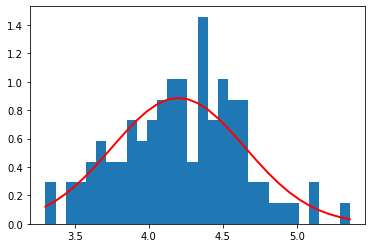

bins =  [3.30112997 3.64379256 3.98645515 4.32911774 4.67178033 5.01444291
 5.3571055 ]
count =  [ 9. 19. 28. 34.  7.  3.]
BH Masses =  [  2000.46046073   4403.44483938   9692.93161952  21336.23261057
  46965.64877188 103381.52029102 227565.01862871]


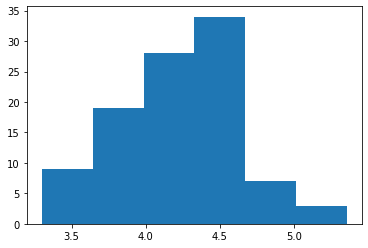

In [4]:
#Ok let's test the model
#First up we need a normal distribution of heavy seed masses
np.random.seed(131180)

#Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
mu, sigma = 4.2, 0.45 # mean and standard deviation
#mu, sigma = 4.9, 0.35 # mean and standard deviation
s = np.random.normal(mu, sigma, 100)


masses = np.power(10, s)
#print("masses = ", masses)
print("masses.sum = %e Msolar" % (masses.sum()))
count, bins, ignored = plt.hist(s, 30, density=True)

plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')

plt.show()

#To do this I recreate the above histogram without normalising
#and I divide into 5 bins
count, bins, ignored = plt.hist(s, 6, density=False)



print("bins = ", bins)
print("count = ", count)
print("BH Masses = ", np.power(10.0, bins))

In [5]:
#Now calculate the dynamical friction time for each mass bin
#
massbins = np.power(10, bins[1::])
DyTime = []
print("bins = ", massbins)
for M_BH, N_tot in zip(massbins, count):
    M_BH = YTQuantity(M_BH, 'Msun')
    print("M_BH = ", M_BH)
    t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
    YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
    print("t_df = ", t_df)
    print("")
    DyTime.append(t_df)
    
 

bins =  [  4403.44483938   9692.93161952  21336.23261057  46965.64877188
 103381.52029102 227565.01862871]
M_BH =  4403.444839376569 Msun
t_df =  433.9329571972911 Gyr

M_BH =  9692.931619523439 Msun
t_df =  197.13332519101905 Gyr

M_BH =  21336.232610571053 Msun
t_df =  89.55657148484207 Gyr

M_BH =  46965.64877188091 Msun
t_df =  40.68505154239138 Gyr

M_BH =  103381.52029102022 Msun
t_df =  18.482992275862266 Gyr

M_BH =  227565.01862871158 Msun
t_df =  8.396720429704665 Gyr



In [6]:
#Calculate the number of mergers for each mass bin in a hubble time
Epsilon = []
for M_BH, Num_HeavySeeds, t_df in zip(massbins, count, DyTime):
    new_radius = NewRadius(R_0, tau_hubble, t_df)
    N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

    #print("N_tot number density = ", N_tot)
    
    #print("Ntot in Galaxy = ", N_tot*np.power(new_radius, 3.0))
    print("Merger Rate = ", MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot).to("Gyr**-1"))

    N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

    #Total number of mergers in a Hubble Time
    print("Total Number of Mergers in a Hubble Time = ", N_mm)
    N_mm =  min(Num_HeavySeeds, N_mm)
    epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
    Epsilon.append(epsilon)
    print("epsilon = ", epsilon)
    print("")

Merger Rate =  2.2731339757130683e-05 1/Gyr
Total Number of Mergers in a Hubble Time =  0.002823232397835629 dimensionless
epsilon =  0.9996863075113516 dimensionless

Merger Rate =  0.00024623352447211537 1/Gyr
Total Number of Mergers in a Hubble Time =  0.06456243011658862 dimensionless
epsilon =  0.9966019773622848 dimensionless

Merger Rate =  0.0019946007413626198 1/Gyr
Total Number of Mergers in a Hubble Time =  0.7707137264625158 dimensionless
epsilon =  0.9724745097691959 dimensionless

Merger Rate =  0.015491120860683166 1/Gyr
Total Number of Mergers in a Hubble Time =  7.268433907832538 dimensionless
epsilon =  0.7862225321225724 dimensionless

Merger Rate =  0.028474197425176602 1/Gyr
Total Number of Mergers in a Hubble Time =  2.7506074712720583 dimensionless
epsilon =  0.6070560755325631 dimensionless

Merger Rate =  0.22701581399507087 1/Gyr
Total Number of Mergers in a Hubble Time =  9.398454699395929 dimensionless
epsilon =  0.0 dimensionless



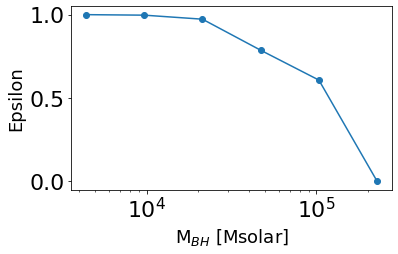

In [7]:
#Now plot the
#1. #Number of black holes at the start in each bin
#2. Overplot the number of black holes at the end

#Plot Epsilon against M_BH
#font = {'family' : 'normal',
#        'weight' : 'bold',
#        'size'   : 18}

#matplotlib.rc('font', **font)
plt.rcParams.update({'font.size': 22})
plt.figure()
plt.semilogx(massbins, Epsilon, marker="o")
plt.xlabel("M$_{BH}$ [Msolar]", fontsize="18")
plt.ylabel("Epsilon", fontsize="18")
plt.tight_layout()
plt.savefig("EpsilonVsMass.pdf")

In [ ]:
NUMBINS = 20
BinMasses = np.logspace(3, 6, NUMBINS)
Binned_Mass = {}
Binned_Epsilon = {}

for i in range(NUMBINS):
    Binned_Mass[i] = []
    Binned_Epsilon[i] = []
    
def delta_bin(m, e):
    for i in range(NUMBINS-1):
        if(m > BinMasses[i] and m < BinMasses[i+1]):
            if(e < 0.0):
                continue
            Binned_Mass[i].append(int(m))
            Binned_Epsilon[i].append(e)
            
#Ok let's run a MC simulation
#First up we need a normal distribution of heavy seed masses
np.random.seed(131180)
plt.figure()
for i in range(10000):
    #Set up a normal (in log10 space) distribution. Set the mean at 2e4 with a standard deviation of 0.45 ish
    mu, sigma = 4.2, 0.45 # mean and standard deviation
    #mu, sigma = 4.9, 0.35 # mean and standard deviation
    s = np.random.normal(mu, sigma, 100)


    masses = np.power(10, s)
   
    #To do this I recreate the above histogram without normalising
    #and I divide into 5 bins
    count, bins, ignored = plt.hist(s, 6, density=False)
  
    #Now calculate the dynamical friction time for each mass bin
    #     
    
    #Calculate the number of mergers for each mass bin in a hubble time
    massbins = np.power(10, bins[1::])
    DyTime = []
    Epsilon = []
    Masses = []
    #print("bins = ", massbins)
    for M_BH, Num_HeavySeeds in zip(massbins, count):
        M_BH = YTQuantity(M_BH, 'Msun')
        #print("M_BH = ", M_BH)
        t_df = YTQuantity(2 * (v_bh / YTQuantity(10, 'km/s')) * YTQuantity(3e6, 'Msun/kpc**3')/background_density * \
        YTQuantity(3e5, 'Msun')/M_BH, 'Gyr')
        #print("t_df = ", t_df)
        #print("")
        DyTime.append(t_df)
        new_radius = NewRadius(R_0, tau_hubble, t_df)
        N_tot = Num_HeavySeeds/np.power(new_radius, 3.0)

        N_mm = N_tot * np.power(new_radius, 3.0) * MergerRate(YTQuantity(M_BH, 'Msun'), v_bh, cs, N_tot) * tau_hubble
    

        #Total number of mergers in a Hubble Time
        #print("Total Number of Mergers in a Hubble Time = ", N_mm)
        N_mm =  min(Num_HeavySeeds, N_mm)
        epsilon = 1 - (N_mm / (N_tot * np.power(new_radius, 3.0)))
        Epsilon.append(epsilon.v)
        
       
        delta_bin(M_BH.v, epsilon.v)
 
    plt.semilogx(massbins, Epsilon, color='red', alpha=0.025)

FinalM = []
FinalE = []
for i in range(NUMBINS):
    FinalM.append(np.mean(np.asarray(Binned_Mass[i])))
    FinalE.append(np.mean(np.asarray(Binned_Epsilon[i])))
plt.semilogx(FinalM, FinalE, marker="*", color='blue')

plt.xlabel("M$_{BH}$ [Msolar]", fontsize="18")
plt.ylabel("Epsilon", fontsize="18")
plt.xlim(5e2, 1e6)
plt.ylim(-0.1,1.2)
plt.xticks((1e3, 1e4, 1e5, 1e6))
plt.tight_layout()
plt.savefig("EpsilonVsMass_MC.pdf")



/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/regan/.local/lib/python3.9/site-packages/unyt/array.py:1778: RuntimeWarning: invalid value encountered in true_divide
  out_arr = func(
/home/